In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'dms-driver-monitoring-system:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3866230%2F6708441%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240312%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240312T125941Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Daa20aa042938f92cf3a0d9709546842d8f1ed859ce1e414e375d11015636b4f54cf5e2537fa6b194751770f972ead246de915c5c7a8c92f68b3259a4fd343e80e3926b27a0d9b33b08eaa381605429e0a9591de92066d4dd11c738e7292d27e7c70938ec134ab27873559059a347ecb82fe0c78bfba93990a81c058a3d7e049fe9087d6823157cfd8256c89fbd4600f6a460a1d1e6a1af4e77e48712b8c67a26fe64463548a87d72c1a215d66262328511d05700c9b44f30dabaa49ecf4d0363ee82a976093b989de423aeea5b41ef97b9c57893381b5eecb37b01dcb44f6b83b07bff5df1574cb08254857b38097f71eb41bd7b78699688730de13c1077729c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 255190609 bytes downloaded
Downloaded and uncompressed: dms-driver-monitoring-system
Data source import complete.


In [ ]:
!pip install supervision
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 8.7 MB/s eta 0:00:00


In [ ]:
from warnings import filterwarnings
filterwarnings(action="ignore")

import os
import yaml
import shutil
import numpy as np
import pandas as pd

import supervision as sv
from ultralytics import YOLO

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
test_labels = "/kaggle/input/dms-driver-monitoring-system/test/labels"
train_labels = "/kaggle/input/dms-driver-monitoring-system/train/labels"
val_labels = "/kaggle/input/dms-driver-monitoring-system/valid/labels"

In [ ]:
data = {"labels":[], "split_type":[]}

for links, split_type in zip([train_labels, test_labels, val_labels], ["train", "test", "val"]):
    for labels in os.listdir(links):
        path = os.path.join(links, labels)
        data["labels"].append(path)
        data["split_type"].append(split_type)

In [ ]:
df = pd.DataFrame(data)

print(df.shape)

df.head()

(9884, 2)


,labels,split_type
0,/kaggle/input/dms-driver-monitoring-system/tra...,train
1,/kaggle/input/dms-driver-monitoring-system/tra...,train
2,/kaggle/input/dms-driver-monitoring-system/tra...,train
3,/kaggle/input/dms-driver-monitoring-system/tra...,train
4,/kaggle/input/dms-driver-monitoring-system/tra...,train


In [ ]:
df.describe().T

,count,unique,top,freq
labels,9884,9884,/kaggle/input/dms-driver-monitoring-system/tra...,1
split_type,9884,3,train,5957


In [ ]:
for index, labels in enumerate(df["labels"]):
    if len(np.loadtxt(labels)) != 0:
        df.loc[index, "is_annotated"] = True
    else:
        df.loc[index, "is_annotated"] = False

In [ ]:
df["is_annotated"].value_counts()

True    9884
Name: is_annotated, dtype: int64

 ### Obserservation:
 * The annotated label seems ok for each rows.

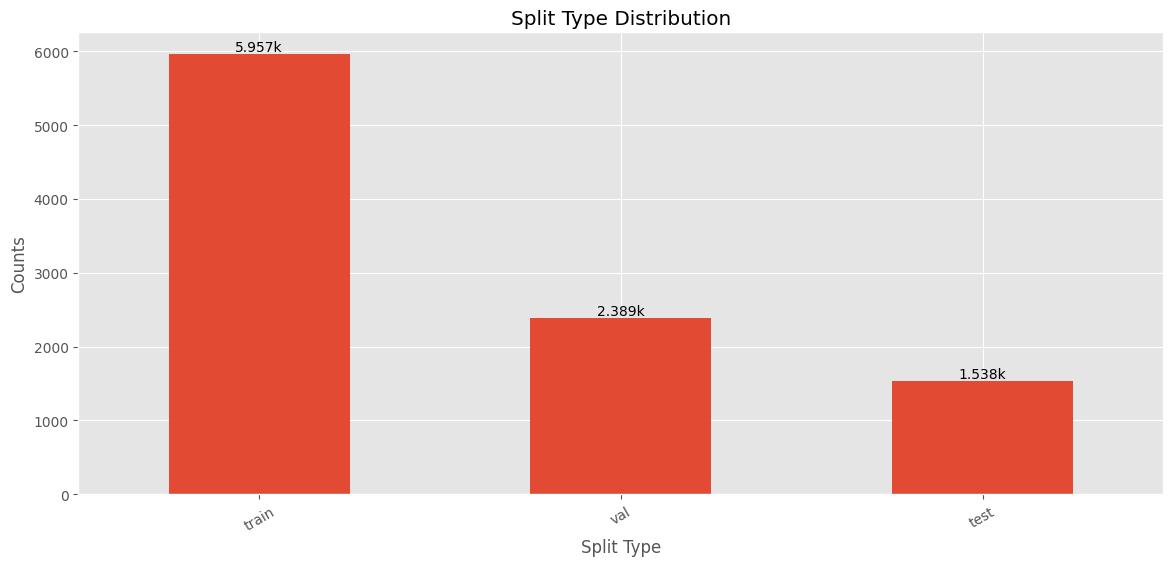

In [ ]:
plt.style.use("ggplot")

plt.figure(figsize=(14, 6))

barplot = df["split_type"].value_counts().plot(kind="bar")

for p in barplot.patches:
    h = p.get_height()
    barplot.text(p.get_x()+(p.get_width()/2), h, f"{h/1000:}k", va="bottom", ha="center")

barplot.set_title("Split Type Distribution")
barplot.set_xlabel("Split Type")
barplot.set_ylabel("Counts")
barplot.set_xticklabels(labels=barplot.get_xticklabels(), rotation=30)
plt.show()

In [ ]:
from tensorflow.keras import optimizers

In [ ]:
model = YOLO('yolov8n.pt')#.load('yolov8n.pt')

model.train(data="/kaggle/input/dms-driver-monitoring-system/data.yaml",
            epochs=20,
            optimizer= "auto",
            imgsz=1070)

Ultralytics YOLOv8.1.27 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/input/dms-driver-monitoring-system/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=1070, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels

train: Scanning /kaggle/input/dms-driver-monitoring-system/train/labels.cache... 5957 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5957/5957 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/dms-driver-monitoring-system/valid/labels.cache... 2389 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2389/2389 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1088 train, 1088 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      7.86G      1.439      2.642      1.416         35       1088: 100%|██████████| 373/373 [05:11<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:39<00:00,  1.89it/s]


                   all       2389       5773      0.692      0.616      0.662       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.97G      1.252      1.396      1.288         36       1088: 100%|██████████| 373/373 [05:05<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:37<00:00,  1.98it/s]


                   all       2389       5773       0.65      0.637       0.66      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      7.22G      1.222      1.129      1.283         27       1088: 100%|██████████| 373/373 [05:04<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:37<00:00,  2.01it/s]

                   all       2389       5773      0.703      0.639      0.689      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      7.19G       1.18     0.9933       1.25         28       1088: 100%|██████████| 373/373 [05:09<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:37<00:00,  1.99it/s]

                   all       2389       5773      0.743      0.676       0.73      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      7.21G      1.148     0.9242      1.239         22       1088: 100%|██████████| 373/373 [05:04<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:37<00:00,  2.00it/s]


                   all       2389       5773      0.764      0.695      0.756      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      7.22G      1.121     0.8883      1.224         17       1088: 100%|██████████| 373/373 [05:05<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:39<00:00,  1.90it/s]


                   all       2389       5773      0.786      0.748      0.801      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      7.16G        1.1     0.8475      1.216         17       1088: 100%|██████████| 373/373 [05:06<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:37<00:00,  1.99it/s]

                   all       2389       5773      0.819      0.753      0.826      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      7.19G      1.062     0.7913      1.183         25       1088: 100%|██████████| 373/373 [05:08<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:36<00:00,  2.03it/s]


                   all       2389       5773      0.802      0.759      0.829      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.98G      1.031     0.7687      1.167         15       1088: 100%|██████████| 373/373 [05:08<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:38<00:00,  1.96it/s]

                   all       2389       5773      0.815      0.765      0.836      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       7.2G      1.029     0.7586      1.168         30       1088: 100%|██████████| 373/373 [05:06<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:37<00:00,  1.98it/s]

                   all       2389       5773      0.853       0.79      0.859      0.563


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      7.41G      1.007     0.6988      1.189          9       1088: 100%|██████████| 373/373 [04:53<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:37<00:00,  2.01it/s]

                   all       2389       5773      0.816      0.772      0.837      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.87G     0.9809     0.6587      1.174         10       1088: 100%|██████████| 373/373 [04:49<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:38<00:00,  1.96it/s]

                   all       2389       5773      0.844      0.799      0.869      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.89G     0.9612      0.638      1.155         14       1088: 100%|██████████| 373/373 [04:48<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:38<00:00,  1.97it/s]

                   all       2389       5773      0.856      0.807      0.875      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      7.13G     0.9344     0.6173      1.145         15       1088: 100%|██████████| 373/373 [04:50<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:38<00:00,  1.93it/s]

                   all       2389       5773      0.845      0.823      0.882      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.88G     0.9221     0.5955      1.138         11       1088: 100%|██████████| 373/373 [04:50<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:37<00:00,  2.01it/s]

                   all       2389       5773      0.859      0.816      0.884       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      7.11G     0.9023     0.5774      1.125         15       1088: 100%|██████████| 373/373 [04:50<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:37<00:00,  1.98it/s]

                   all       2389       5773      0.851      0.833      0.889      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      7.12G     0.8825     0.5536      1.113         12       1088: 100%|██████████| 373/373 [04:49<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:37<00:00,  1.98it/s]

                   all       2389       5773      0.847      0.833      0.886      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      7.11G     0.8668     0.5407      1.106         14       1088: 100%|██████████| 373/373 [04:50<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:38<00:00,  1.97it/s]

                   all       2389       5773      0.881      0.839      0.903      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      7.11G     0.8455     0.5209      1.086         13       1088: 100%|██████████| 373/373 [05:01<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]

                   all       2389       5773      0.879      0.836      0.901      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.88G       0.83     0.5059      1.079         12       1088: 100%|██████████| 373/373 [05:00<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:37<00:00,  1.98it/s]

                   all       2389       5773      0.872      0.842      0.904      0.645



20 epochs completed in 1.884 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.3MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:42<00:00,  1.78it/s]


                   all       2389       5773      0.873       0.84      0.903      0.645
              Open Eye       2389       2710      0.924      0.936      0.978      0.785
            Closed Eye       2389        530      0.813      0.758      0.862      0.663
             Cigarette       2389        453      0.795       0.72      0.791      0.439
                 Phone       2389        588      0.918      0.937      0.964        0.7
              Seatbelt       2389       1492      0.913      0.848      0.921      0.635
Speed: 0.4ms preprocess, 4.2ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7809dca8f220>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

## Eddy